In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

1. Dataset 

In [7]:
HCV_Data = pd.read_csv('C:/Users/DELL/Downloads/hepatitis+c+virus+hcv+for+egyptian+patients/HCV-Egy-Data.csv')
HCV_Data.head()

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
0,56,1,35,2,1,1,1,2,2,2,...,5,5,5,655330,634536,288194,5,5,13,2
1,46,1,29,1,2,2,1,2,2,1,...,57,123,44,40620,538635,637056,336804,31085,4,2
2,57,1,33,2,2,2,2,1,1,1,...,5,5,5,571148,661346,5,735945,558829,4,4
3,49,2,33,1,2,1,2,1,2,1,...,48,77,33,1041941,449939,585688,744463,582301,10,3
4,59,1,32,1,1,2,1,2,2,2,...,94,90,30,660410,738756,3731527,338946,242861,11,1


2. Feature selection

In [8]:
# used colums: age, BMI, Plat, AST1, ALT1, BHS.
Data = pd.DataFrame()

Data["Age"] = HCV_Data["Age "]
Data["BMI"] = HCV_Data["BMI"]
Data["Plat"] = HCV_Data["Plat"]
Data["AST1"] = HCV_Data["AST 1"]
Data["ALT1"] = HCV_Data["ALT 1"]
Data["BHS"] = HCV_Data["Baselinehistological staging"]

Data.head()

,Age,BMI,Plat,AST1,ALT1,BHS
0,56,35,112132.0,99,84,2
1,46,29,129367.0,91,123,2
2,57,33,151522.0,113,49,4
3,49,33,146457.0,43,64,3
4,59,32,187684.0,99,104,1


In [25]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     1385 non-null   int64  
 1   BMI     1385 non-null   int64  
 2   Plat    1385 non-null   float64
 3   AST1    1385 non-null   int64  
 4   ALT1    1385 non-null   int64  
 5   BHS     1385 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 65.1 KB


In [10]:
Data.describe()

,Age,BMI,Plat,AST1,ALT1,BHS
count,1385.000000,1385.000000,1385.00000,1385.000000,1385.000000,1385.000000
mean,46.319134,28.608664,158348.06065,82.774729,83.916245,2.536462
std,8.781506,4.076215,38794.78555,25.993242,25.922800,1.121392
min,32.000000,22.000000,93013.00000,39.000000,39.000000,1.000000
25%,39.000000,25.000000,124479.00000,60.000000,62.000000,2.000000
50%,46.000000,29.000000,157916.00000,83.000000,83.000000,3.000000
75%,54.000000,32.000000,190314.00000,105.000000,106.000000,4.000000
max,61.000000,35.000000,226464.00000,128.000000,128.000000,4.000000


"No data cleanup was performed as the downloaded dataset appeared clean, without missing or out-of-range values."

3. Clone dataset for each experiment

In [11]:
A = Data.copy()
B = Data.copy()
C = Data.copy()

In [12]:
A["Lable"] = A["BHS"].replace({
    1:0,
    2:1,
    3:1,
    4:1
})
A=A.drop("BHS",axis=1)

B["Lable"] = B["BHS"].replace({
    1:0,
    2:0,
    3:1,
    4:1
})
B=B.drop("BHS",axis=1)

C["Lable"] = C["BHS"].replace({
    1:0,
    2:0,
    3:0,
    4:1
})
C=C.drop("BHS",axis=1)

In [13]:
A.head()

,Age,BMI,Plat,AST1,ALT1,Lable
0,56,35,112132.0,99,84,1
1,46,29,129367.0,91,123,1
2,57,33,151522.0,113,49,1
3,49,33,146457.0,43,64,1
4,59,32,187684.0,99,104,0


4. Oversample minority class in the datasets 

In [14]:
def oversample(df):
    majority = df[df.Lable == 0]
    minority = df[df.Lable == 1]
    new_min = resample(
        minority,
        replace = True,
        n_samples = len(majority),
        random_state = 101)
    return pd.concat([majority,new_min])

In [15]:
A_balanced = oversample(A)
B_balanced = oversample(B)
C_balanced = C

In [16]:
A_y = A_balanced["Lable"]
A_x = A_balanced.drop("Lable",axis=1)
B_y = A_balanced["Lable"]
B_x = A_balanced.drop("Lable",axis=1)
C_y = A_balanced["Lable"]
C_x = A_balanced.drop("Lable",axis=1)

5. Standardize data 

In [17]:
Scaler = StandardScaler()
A_x = Scaler.fit_transform(A_x)
B_x = Scaler.fit_transform(B_x)
C_x = Scaler.fit_transform(C_x)

In [18]:
T_x = A_x.copy()
T_y = A_y.copy()

6. Hyperparameter optimization
   “Estimate best values for hyperparameters for each ML classifier algorithm and perform k-fold validation.”
• Logistic Regression 
• Naïve Bayes 
• Decision Tree 
• Random Forest 
• Extreme Gradient Boosting 
• k-Nearest Neighbor 
• Support Vector Machine 
• Neural Networks 
• Ensemble Method 

In [26]:
# Logisitic Regression
lr = LogisticRegression(max_iter=500)

param_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_lr = GridSearchCV(lr, param_lr, cv=cv, scoring='accuracy')
grid_lr.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

In [27]:
#Naïve Bayes
nb = GaussianNB()

param_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_nb = GridSearchCV(nb, param_nb, cv=cv, scoring='accuracy')
grid_nb.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]},
             scoring='accuracy')

In [28]:
#Decision Tree
dt = DecisionTreeClassifier()

param_dt = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(dt, param_dt, cv=cv, scoring='accuracy')
grid_dt.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [29]:
# Random Forest
rf = RandomForestClassifier()

param_rf = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(rf, param_rf, cv=cv, scoring='accuracy')
grid_rf.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='accuracy')

In [ ]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(A_x, A_y)

In [30]:
#k-Nearest Neighbor
knn = KNeighborsClassifier()

param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(knn, param_knn, cv=cv, scoring='accuracy')
grid_knn.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [31]:
#Support Vector Machine
svm = SVC()

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(svm, param_svm, cv=cv, scoring='accuracy')
grid_svm.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [32]:
#Neural Networks
mlp = MLPClassifier(max_iter=1000)

param_mlp = {
    'hidden_layer_sizes': [(10,), (20,), (50,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

grid_mlp = GridSearchCV(mlp, param_mlp, cv=cv, scoring='accuracy')
grid_mlp.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=MLPClassifier(max_iter=1000),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(10,), (20,), (50,)],
                         'learning_rate': ['constant', 'adaptive']},
             scoring='accuracy')

In [33]:
#Ensemble Method
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=300)),
    ('svm', SVC(probability=True))
], voting='soft')

# Minimal hyperparameter tuning:
param_ens = {
    'voting': ['soft']
}

grid_ens = GridSearchCV(ensemble, param_ens, cv=cv, scoring='accuracy')
grid_ens.fit(A_x, A_y)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(max_iter=500)),
                                                    ('rf',
                                                     RandomForestClassifier(n_estimators=300)),
                                                    ('svm',
                                                     SVC(probability=True))],
                                        voting='soft'),
             param_grid={'voting': ['soft']}, scoring='accuracy')

7. Split the datasets into “Train” and “Test” sets

In [34]:
A_x_train, A_x_test, A_y_train, A_y_test = train_test_split(A_x,A_y,test_size=0.3,random_state=101)
B_x_train, B_x_test, B_y_train, B_y_test = train_test_split(B_x,B_y,test_size=0.3,random_state=101)
C_x_train, C_x_test, C_y_train, C_y_test = train_test_split(C_x,C_y,test_size=0.3,random_state=101)


In [43]:
B_y_test

520     0
1143    1
619     0
1247    1
1292    0
       ..
98      1
462     1
713     1
1365    0
4       0
Name: Lable, Length: 202, dtype: int64

8. Fit the “Train” sets 

In [35]:
best_lr = LogisticRegression(max_iter=500, **grid_lr.best_params_)
best_rf = RandomForestClassifier(**grid_rf.best_params_)
best_dt = DecisionTreeClassifier(**grid_dt.best_params_)
best_knn = KNeighborsClassifier(**grid_knn.best_params_)
best_svm = SVC(**grid_svm.best_params_)
best_mlp = MLPClassifier(max_iter=1000, **grid_mlp.best_params_)
best_nb = GaussianNB(**grid_nb.best_params_)
best_ens = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500, **grid_lr.best_params_)),
    ('rf', RandomForestClassifier(**grid_rf.best_params_)),
    ('svm', SVC(probability=True, **grid_svm.best_params_))
], voting='soft')


In [37]:
# Dictionary of the models you built
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "Decision Tree": best_dt,
    "KNN": best_knn,
    "SVM": best_svm,
    "Neural Network (MLP)": best_mlp,
    "Naive Bayes": best_nb,
    "Ensemble": best_ens
}

# Storing all results
results = {
    "Experiment A": [],
    "Experiment B": [],
    "Experiment C": []
}

# A helper function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    try:
        probs = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
    except:
        auc = None

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    cm = confusion_matrix(y_test, preds)

    return preds, acc, prec, rec, f1, auc, cm

In [44]:
for name, model in models.items():
    preds, acc, prec, rec, f1, auc, cm = evaluate_model(
        model, A_x_train, A_y_train, A_x_test, A_y_test
    )
    results["Experiment A"].append([name, acc, prec, rec, f1, auc, cm])


In [41]:
for name, model in models.items():
    preds, acc, prec, rec, f1, auc, cm = evaluate_model(
        model, B_x_train, B_y_train, B_x_test, B_y_test
    )
    results["Experiment B"].append([name, acc, prec, rec, f1, auc, cm])


In [42]:
# EXPERIMENT C
for name, model in models.items():
    preds, acc, prec, rec, f1, auc, cm = evaluate_model(
        model, C_x_train, C_y_train, C_x_test, C_y_test
    )
    results["Experiment C"].append([name, acc, prec, rec, f1, auc, cm])

9. Evaluate the “Test” sets and extract the evaluation parameters

In [45]:
df_A = pd.DataFrame(results["Experiment A"], 
                    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Confusion Matrix"])

df_B = pd.DataFrame(results["Experiment B"], 
                    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Confusion Matrix"])

df_C = pd.DataFrame(results["Experiment C"], 
                    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Confusion Matrix"])

# Save everything to Excel or CSV
df_A.to_csv("ExperimentA_results.csv", index=False)
df_B.to_csv("ExperimentB_results.csv", index=False)
df_C.to_csv("ExperimentC_results.csv", index=False)

df_A, df_B, df_C

(                  Model  Accuracy  Precision    Recall  F1 Score       AUC  \
 0   Logistic Regression  0.465347   0.446281  0.568421  0.500000  0.454206   
 1         Random Forest  0.574257   0.542056  0.610526  0.574257  0.605017   
 2         Decision Tree  0.559406   0.527273  0.610526  0.565854  0.562273   
 3                   KNN  0.589109   0.554545  0.642105  0.595122  0.645844   
 4                   SVM  0.544554   0.514563  0.557895  0.535354       NaN   
 5  Neural Network (MLP)  0.500000   0.471698  0.526316  0.497512  0.490802   
 6           Naive Bayes  0.490099   0.467213  0.600000  0.525346  0.459026   
 7              Ensemble  0.554455   0.520000  0.684211  0.590909  0.605607   
 
        Confusion Matrix  
 0  [[40, 67], [41, 54]]  
 1  [[58, 49], [37, 58]]  
 2  [[55, 52], [37, 58]]  
 3  [[58, 49], [34, 61]]  
 4  [[57, 50], [42, 53]]  
 5  [[51, 56], [45, 50]]  
 6  [[42, 65], [38, 57]]  
 7  [[47, 60], [30, 65]]  ,
                   Model  Accuracy  Precisi

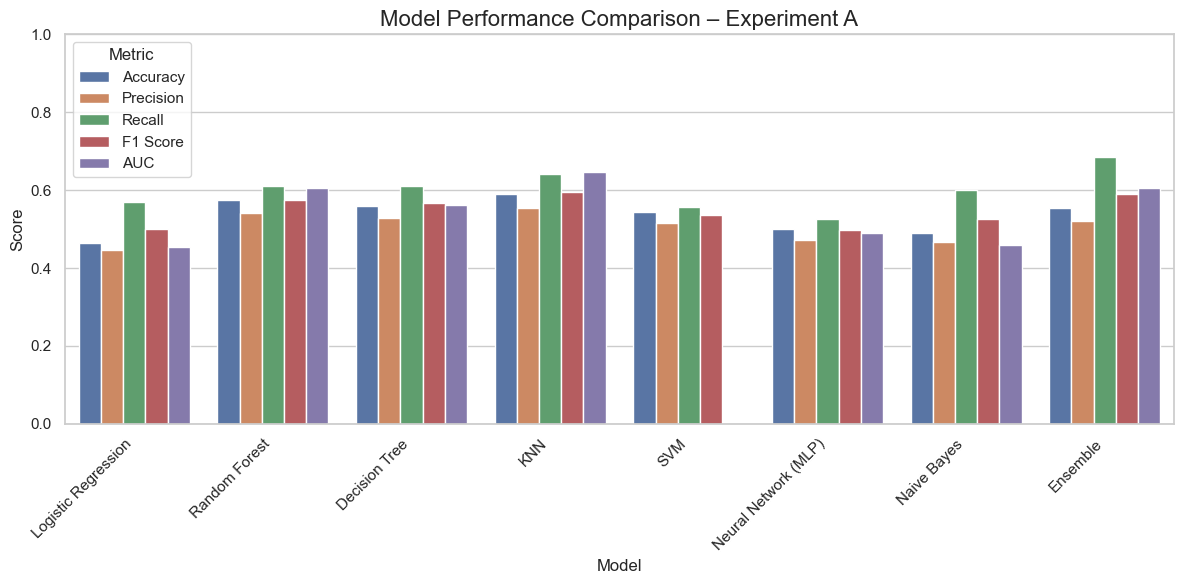

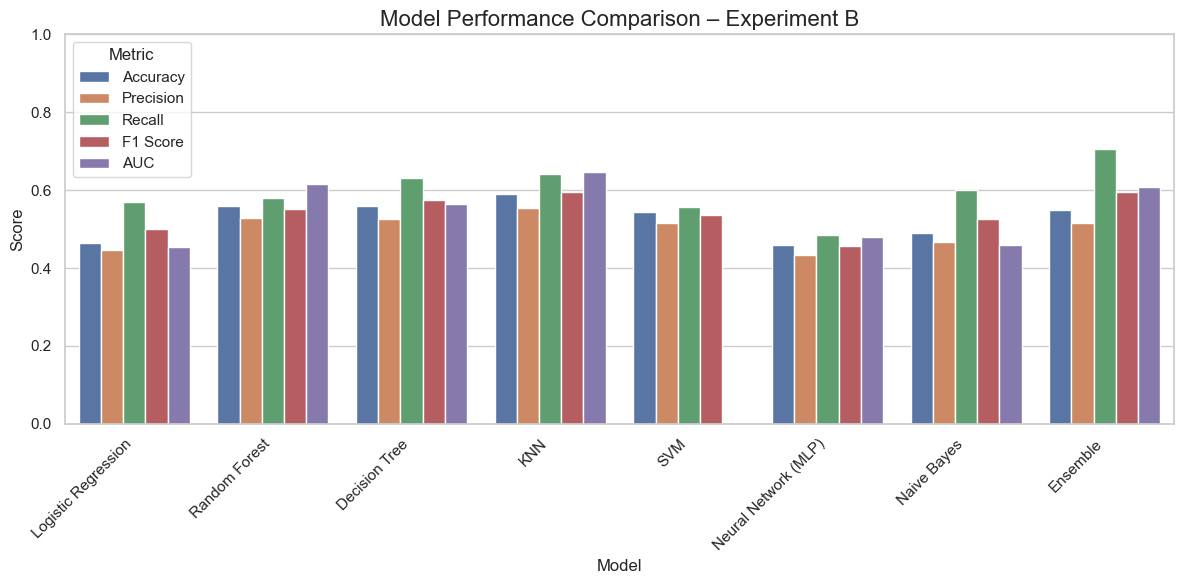

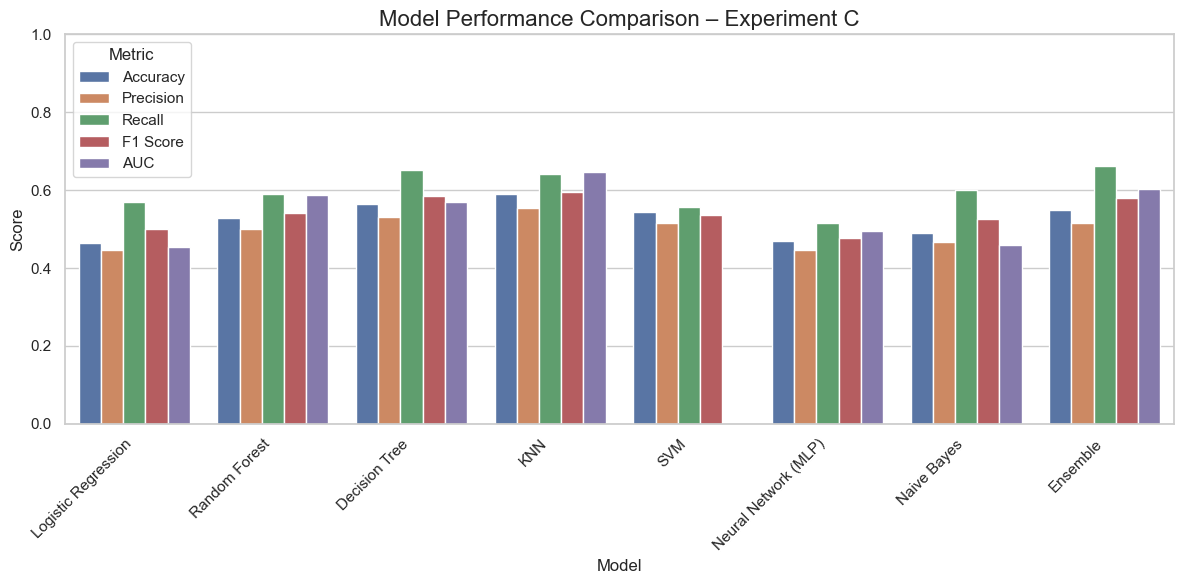

In [46]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

def plot_metrics(df, experiment_name):
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
    
    # Melt the dataframe to long-form for seaborn
    df_melt = df.melt(id_vars=["Model"], value_vars=metrics,
                      var_name="Metric", value_name="Score")

    # Drop rows where score is None (AUC for SVM w/out probability)
    df_melt = df_melt.dropna(subset=["Score"])

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x="Model", y="Score", hue="Metric")
    plt.title(f"Model Performance Comparison – {experiment_name}", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()



# ============================
# 📊 PLOT FOR EACH EXPERIMENT
# ============================

plot_metrics(df_A, "Experiment A")
plot_metrics(df_B, "Experiment B")
plot_metrics(df_C, "Experiment C")